In [42]:
import os
import pathlib
import pandas as pd
import numpy as np
import gc
from skimage import io
import matplotlib.pyplot as plt
import scipy.linalg as lng
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sys import getsizeof
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans

%matplotlib inline
%run my_functions.ipynb

## Paths

In [2]:
data_path = '../data/Faces/'
labels_path = '../data/labels.csv'
result_path = '../results'
names_path = "../data/filenames.txt"
file_data_path = "../files"
data_set_gray_npy = os.path.join(file_data_path, 'data_gray.npy')
data_set_rgb_npy = os.path.join(file_data_path, 'data_rgb.npy')
labels_csv_path = os.path.join(file_data_path, 'data_rgb.npy')

## Nr of data, Labels etc

In [3]:
# Open a random image to get dimensions
h, w = get_dimensions_from_an_image(data_path, 0, as_gray=True)

In [4]:
# Get labels as pandas object from labels.csv
labels = get_labels_df(
    labels_path=labels_path, names_path=names_path)
labels

,actual_filename,image_no,age,gender,race
0,100_0_0_20170112213500903.jpg.chip.jpg,0,100,0,0
1,100_0_0_20170112215240346.jpg.chip.jpg,1,100,0,0
2,100_1_0_20170110183726390.jpg.chip.jpg,2,100,1,0
3,100_1_0_20170112213001988.jpg.chip.jpg,3,100,1,0
4,100_1_0_20170112213303693.jpg.chip.jpg,4,100,1,0
...,...,...,...,...,...
23700,9_1_3_20161220222856346.jpg.chip.jpg,23700,9,1,3
23701,9_1_3_20170104222949455.jpg.chip.jpg,23701,9,1,3
23702,9_1_4_20170103200637399.jpg.chip.jpg,23702,9,1,4
23703,9_1_4_20170103200814791.jpg.chip.jpg,23703,9,1,4


## Read Data (Grey)

In [5]:
X = np.load(data_set_gray_npy)
dirs = os.listdir(data_path)

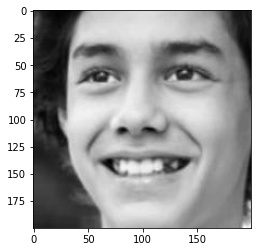

In [6]:
# Show an image for verification
plt.imshow(X[100].reshape(200,200), cmap=plt.cm.gray)

In [7]:
start_age = 15
end_age = 70
cut_index = labels.query('age >= @start_age and age <= @end_age')

In [8]:
cut_index

,actual_filename,image_no,age,gender,race
621,15_0_0_20170102234355667.jpg.chip.jpg,621,15,0,0
622,15_0_0_20170103200828591.jpg.chip.jpg,622,15,0,0
623,15_0_0_20170103200850696.jpg.chip.jpg,623,15,0,0
624,15_0_0_20170103201110847.jpg.chip.jpg,624,15,0,0
625,15_0_0_20170103201301966.jpg.chip.jpg,625,15,0,0
...,...,...,...,...,...
21939,70_1_2_20170110181645374.jpg.chip.jpg,21939,70,1,2
21940,70_1_3_20170109134219121.jpg.chip.jpg,21940,70,1,3
21941,70_1_3_20170109142852824.jpg.chip.jpg,21941,70,1,3
21942,70_1_3_20170116224931319.jpg.chip.jpg,21942,70,1,3


In [9]:
X = X[cut_index.index]

# Only first 8000 data for testing

In [10]:
X_cut = X[:8000,:]

In [11]:
# Do PCA before clustering. Classic case of dimensiolity reduction
# We will now use PCA on our dataset to reduce our dimensions. We will pick our retained variance of 0.98 
# This needs to be explained using image reconstruction error and components to variance analysis
variance = 0.98 
pca = PCA(variance)
pca.fit(X_cut)

PCA(n_components=0.98)

In [12]:
print("Number of components before PCA  = " + str(X_cut.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_)) 

Number of components before PCA  = 40000
Number of components after PCA 0.98 = 436


In [14]:
X_cut_transformed = pca.transform(X_cut)

Dimension of our data after PCA = (8000, 40000)


In [15]:
print("Dimension of our data after PCA = " + str(X_cut_transformed.shape))

Dimension of our data after PCA = (8000, 436)


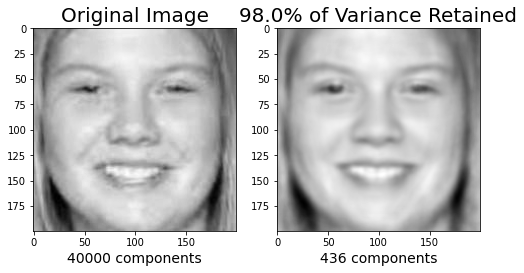

In [18]:
# Inverse transform the data to view how the data changes because of the PCA.
approximation = pca.inverse_transform(X_cut_transformed)

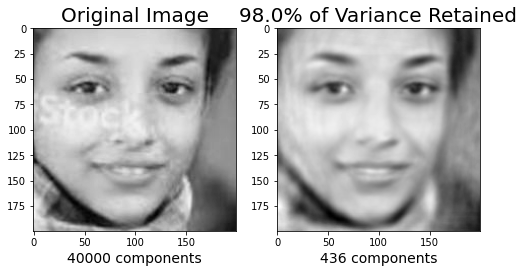

In [34]:
#image reconstruction using the less dimensioned data
plt.figure(figsize=(8,4));
n = 561 #index value, change to view different data
# Original Image
plt.subplot(1, 2, 1);
plt.imshow(X_cut[n].reshape(200, 200),
 cmap = plt.cm.gray,);
plt.xlabel(str(X_cut.shape[1])+' components', fontsize = 14)
plt.title('Original Image', fontsize = 20);
# 196 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[n].reshape(200, 200),
 cmap = plt.cm.gray,);
plt.xlabel(str(X_cut_transformed.shape[1]) +' components', fontsize = 14)
plt.title(str(variance * 100) + '% of Variance Retained', fontsize = 20);

In [38]:
# Do the clustering on the reduced data in terms of dimensions
k_means = KMeans(init = "k-means++", n_clusters = 2, n_init = 60)
k_means.fit(X_cut_transformed)

KMeans(n_clusters=2, n_init=60)

In [30]:
k_means.labels_

array([1, 0, 0, ..., 1, 0, 1], dtype=int32)

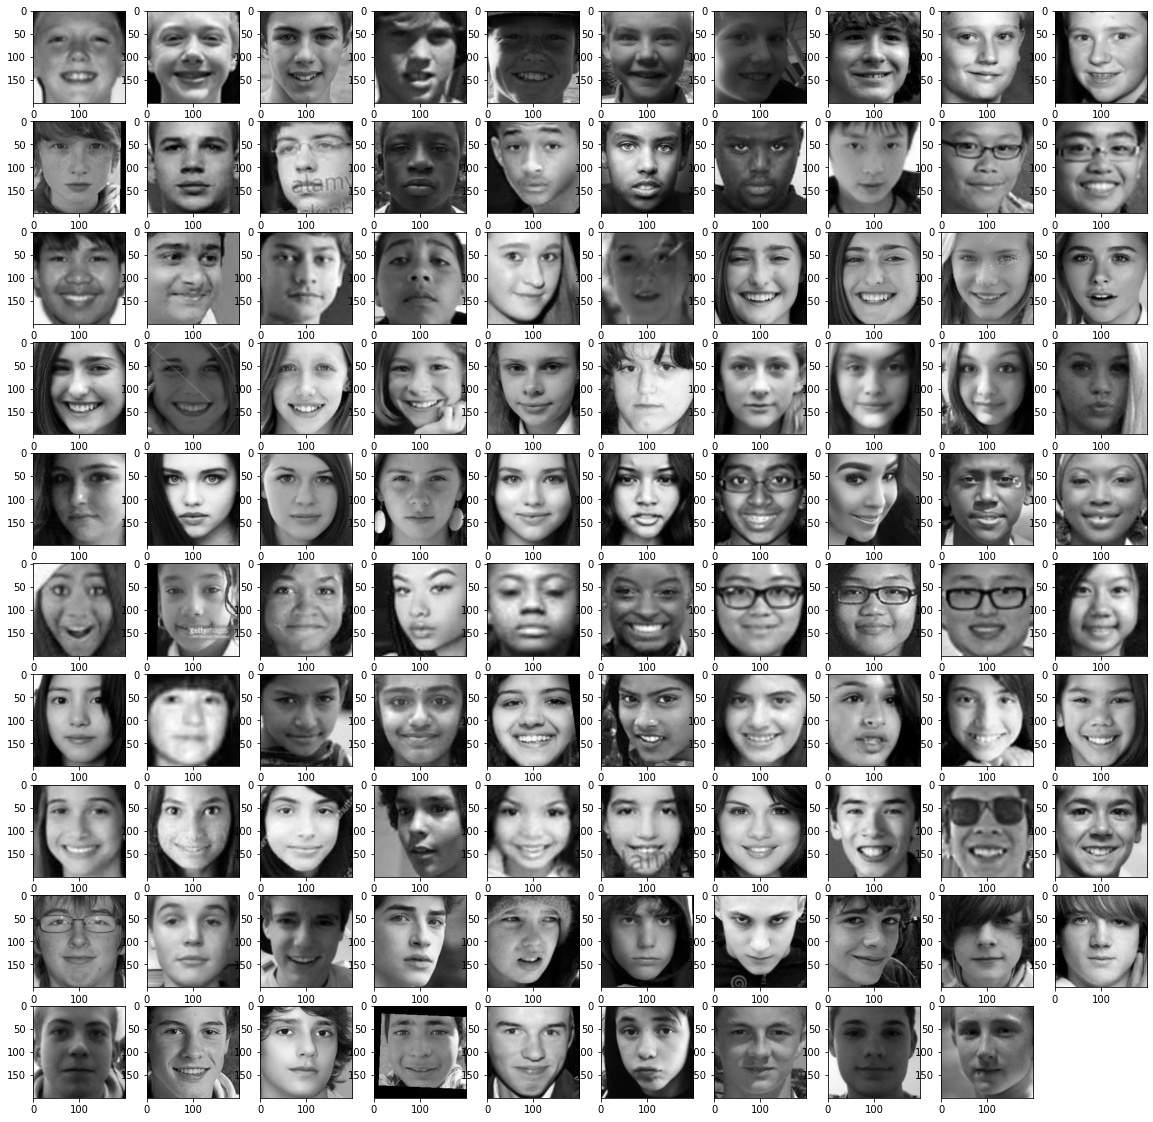

In [58]:
G = len(np.unique(k_means.labels_)) #Number of labels

#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(G)]
for i, label in enumerate(k_means.labels_,0):
    cluster_index[label].append(i)
            
#Visualisation for clusters = clust
plt.figure(figsize=(20,20));
clust = 0 #enter label number to visualise
num = 100 #num of data to visualize from the cluster
for i in range(1,num): 
    plt.subplot(10, 10, i); #(Number of rows, Number of column per row, item number)
    plt.imshow(X_cut[cluster_index[clust][i-1]].reshape(200, 200), cmap = plt.cm.gray);
    
plt.show()

In [56]:
cluster_index[0]

[0,
 9,
 18,
 20,
 27,
 28,
 34,
 40,
 42,
 43,
 45,
 46,
 56,
 58,
 59,
 63,
 65,
 66,
 68,
 69,
 73,
 75,
 82,
 88,
 98,
 100,
 101,
 104,
 106,
 107,
 109,
 111,
 112,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 126,
 128,
 129,
 130,
 132,
 133,
 134,
 137,
 138,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 150,
 154,
 164,
 166,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 182,
 184,
 188,
 189,
 190,
 191,
 198,
 200,
 203,
 206,
 213,
 217,
 219,
 225,
 226,
 228,
 233,
 234,
 235,
 238,
 244,
 245,
 248,
 250,
 253,
 255,
 256,
 258,
 259,
 261,
 262,
 267,
 268,
 270,
 274,
 278,
 279,
 288,
 289,
 290,
 291,
 293,
 294,
 295,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 306,
 307,
 310,
 312,
 313,
 314,
 320,
 321,
 325,
 327,
 331,
 332,
 335,
 336,
 338,
 342,
 344,
 345,
 351,
 353,
 356,
 358,
 361,
 367,
 371,
 373,
 374,
 376,
 377,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 388,
 389,
 390,
 391,
 393,
 394,
 395,
 396,
 397,
 400,
 404,
 406,
 407,
 408,
 409,
 

In [ ]:
#image reconstruction using the less dimensioned data
plt.figure(figsize=(8,4));
n = 561 #index value, change to view different data
# Original Image
plt.subplot(1, 2, 1);
plt.imshow(X_cut[n].reshape(200, 200),
 cmap = plt.cm.gray,);
plt.xlabel(str(X_cut.shape[1])+' components', fontsize = 14)
plt.title('Original Image', fontsize = 20);
# 196 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[n].reshape(200, 200),
 cmap = plt.cm.gray,);
plt.xlabel(str(X_cut_transformed.shape[1]) +' components', fontsize = 14)
plt.title(str(variance * 100) + '% of Variance Retained', fontsize = 20);

In [43]:
variance = 0.985
n_clusters = 2
preprocessor = Pipeline(
    [
         ("scaler", MinMaxScaler()),
         ("pca", PCA(variance)),
     ]
)

clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=n_clusters,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
 )

pipe = Pipeline(
     [
         ("preprocessor", preprocessor),
         ("clusterer", clusterer)
     ]
)

In [44]:
pipe.fit(X_cut)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=0.985))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=2, n_init=50,
                                         random_state=42))]))])

In [45]:
preprocessed_data = pipe["preprocessor"].transform(X_cut)
predicted_labels = pipe["clusterer"]["kmeans"].labels_

In [49]:
preprocessed_data.shape

(8000, 560)

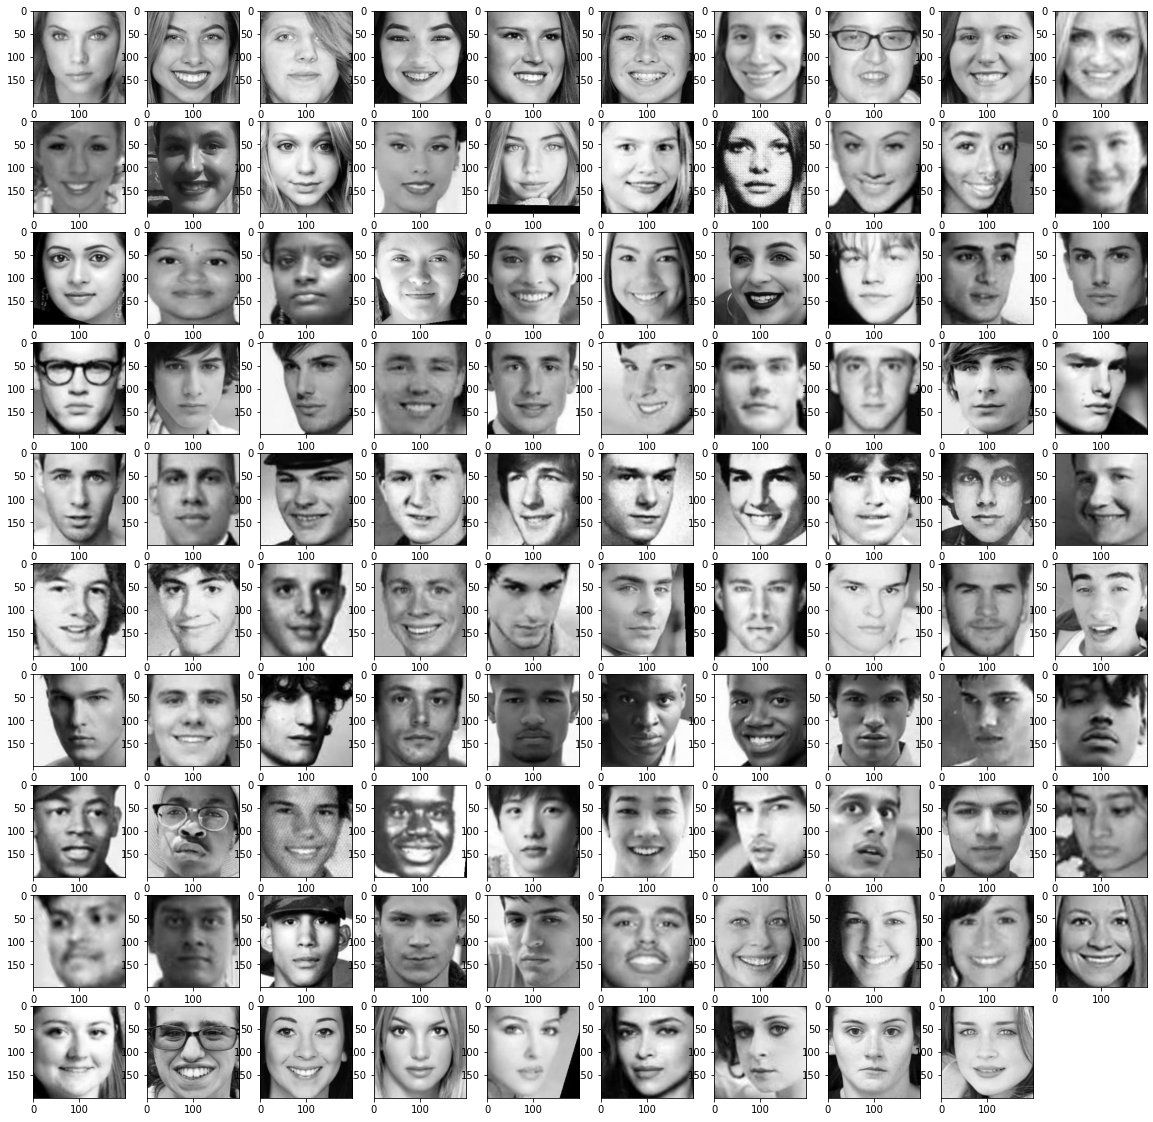

In [51]:
G = len(np.unique(pipe["clusterer"]["kmeans"].labels_)) #Number of labels

#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(G)]
for i, label in enumerate(pipe["clusterer"]["kmeans"].labels_,0):
    for n in range(G):
        if label == n:
            cluster_index[n].append(i)
        else:
            continue
            
#Visualisation for clusters = clust
plt.figure(figsize=(20,20));
clust = 1 #enter label number to visualise
num = 100 #num of data to visualize from the cluster
for i in range(1,num): 
    plt.subplot(10, 10, i); #(Number of rows, Number of column per row, item number)
    plt.imshow(X_cut[cluster_index[clust][i+500]].reshape(200, 200), cmap = plt.cm.gray);
    
plt.show()